In [1]:
from matplotlib import pylab as plt
from sklearn.metrics import mean_squared_error
from itertools import compress

from ase.geometry.analysis import Analysis
from ase.geometry import cellpar_to_cell
import math

from tqdm.notebook import tqdm

from time import time
import rascal
import json
import math

import ase
from ase.io import read, write
from ase.visualize import view
from ase.geometry import wrap_positions
import numpy as np

from rascal.representations import SphericalInvariants
from rascal.models import Kernel, train_gap_model
from rascal.models.asemd import ASEMLCalculator
from rascal.utils import from_dict, to_dict, CURFilter, dump_obj, load_obj, get_score, print_score, FPSFilter

In [2]:
def extract_ref(frames,energy_key=True,forces_key=True,number_key=True):
    e,f,n = [], [], []
    for frame in frames:
        if energy_key:
            e.append(frame.info['energy'])
        if forces_key:
            f.append(frame.get_array('forces'))
        if number_key:
            n.append(len(frame))        
    e = np.array(e)
    n = np.array(n)
    try:
        f = np.concatenate(f)
    except:
        pass
    return e,f,n

In [3]:
N = 4798
frames_train = read('training_data_no_baseline.xyz', index=':{}'.format(N))
N2 = 1601
frames_test = read('test_data_no_baseline.xyz', index=':{}'.format(N2))

np.random.seed(10)
np.random.shuffle(frames_train)

for frame in frames_train:
    frame.set_positions(wrap_positions(frame.get_positions(),frame.get_cell(),eps=1e-10))

### Sorting training set
print('Sorting training set:')
dataset={'P2/P4':[]}
for i in range(N):
    try:
        name=frames_train[i].info['config_type']
        if name in dataset:
            dataset[name].append(i)
        else:
            dataset[name]=[i]
    except:
        dataset['P2/P4'].append(i)
for key in dataset.keys():
    print('Number of frames in '+str(key)+" : "+str(len(dataset[key])))

### Sorting test set
print('Sorting test set:')
dataset2={'P2/P4':[]}
for i in range(N2):
    try:
        name=frames_test[i].info['config_type']
        if name in dataset2:
            dataset2[name].append(i)
        else:
            dataset2[name]=[i]
    except:
        dataset2['P2/P4'].append(i)
for key in dataset2.keys():
    print('Number of frames in '+str(key)+" : "+str(len(dataset2[key])))

print(' ')

### check if we have considered all frames

idxs=list(dataset.values())
n_keys=len(dataset.keys())
checklist=[]
status=True

for i in range(n_keys):
    checklist+=idxs[i]
    
for i in range(N):
    if i in checklist:
        pass
    elif i not in checklist:
        print('Warning: missed frame: '+str(i))
        status=False
if status:
    print('All frames in training set are checked!')


idxs2=list(dataset2.values())
n_keys2=len(dataset2.keys())
checklist2=[]
status2=True

for i in range(n_keys2):
    checklist2+=idxs2[i]
    
for i in range(N2):
    if i in checklist2:
        pass
    elif i not in checklist2:
        print('Warning: missed frame: '+str(i))
        status2=False
if status2:
    print('All frames in test set are checked!')

# modify the test set dictionary
# because the keys are different

del dataset['isolated_atom']
dataset2['cryst_dist'] = dataset2['cryst_dist'] + dataset2['cryst_dist_hp']
del dataset2['cryst_dist_hp']
dataset2['liq_12_03_01_liqP4'] = dataset2['liq_12_03_01_liqP4'] + dataset2['liq_P4']
del dataset2['liq_P4']

Sorting training set:
Number of frames in P2/P4 : 35
Number of frames in rss_200 : 596
Number of frames in rss_005 : 995
Number of frames in 2D : 1234
Number of frames in rss_3c : 400
Number of frames in cryst_dist : 959
Number of frames in liq_12_03_02_network : 164
Number of frames in rss_rnd : 199
Number of frames in liq_12_03_01_liqP4 : 88
Number of frames in phosphorene : 87
Number of frames in phosphorus_ribbons : 40
Number of frames in isolated_atom : 1
Sorting test set:
Number of frames in P2/P4 : 0
Number of frames in 2D : 309
Number of frames in cryst_dist : 241
Number of frames in cryst_dist_hp : 337
Number of frames in liq_12_03_01_liqP4 : 22
Number of frames in liq_12_03_02_network : 41
Number of frames in liq_P4 : 100
Number of frames in rss_005 : 247
Number of frames in rss_200 : 154
Number of frames in rss_3c : 100
Number of frames in rss_rnd : 50
 
All frames in training set are checked!
All frames in test set are checked!


In [4]:
self_contributions = {
    15: -5.157   
}

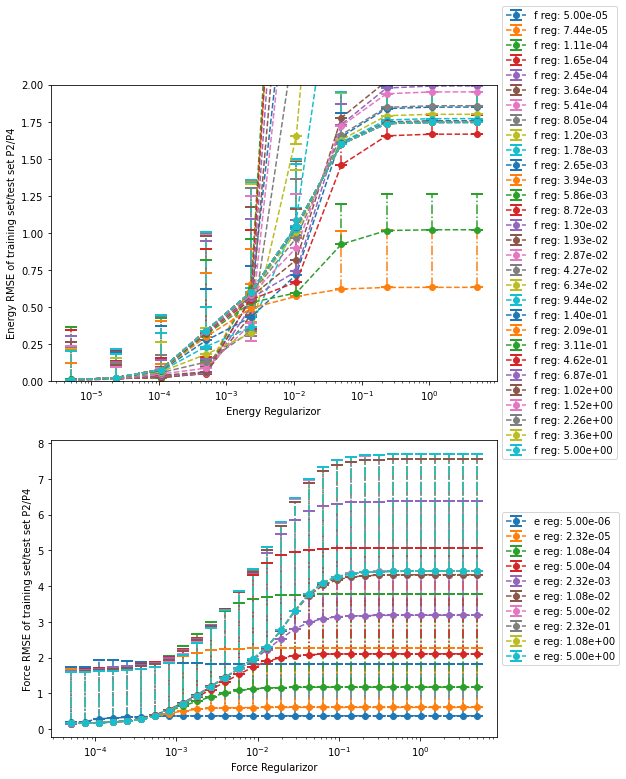

In [24]:
# P2/P4
fig, ax = plt.subplots(nrows=2,figsize=(8,12))
key = 'P2/P4'
e_reg = np.geomspace(5e-6,5,10)
f_reg = np.geomspace(5e-5,5,30)

frames_train_raw = [frames_train[i] for i in dataset[key]]

N = len(dataset[key])
f=int(0.8*N)

ids = list(range(N))
np.random.seed(10)
np.random.shuffle(ids)

frames_train_temp = [frames_train_raw[ii] for ii in ids[:f]]
frames_test_temp = [frames_train_raw[ii] for ii in ids[f:]]
y_train_temp, f_train_temp, n_train_temp = extract_ref(frames_train_temp,True,True,True)
y_test_temp, f_test_temp, n_test_temp = extract_ref(frames_test_temp,True,True,True)
y_train_temp_atom = y_train_temp/n_train_temp
y_test_temp_atom = y_test_temp/n_test_temp

N_temp = len(dataset[key])
if N_temp > 200:
    n_spa = 200
else:
    n_spa = N_temp

hypers = dict(soap_type="PowerSpectrum",
          interaction_cutoff=5, 
          max_radial=6, 
          max_angular=6, 
          gaussian_sigma_constant=0.4,
          gaussian_sigma_type="Constant",
          cutoff_smooth_width=0.5,
          normalize=False,
          radial_basis="GTO",
          compute_gradients=True,
          expansion_by_species_method='structure wise',
          )

soap = SphericalInvariants(**hypers)
managers_train = soap.transform(frames_train_temp)
managers_test = soap.transform(frames_test_temp)

n_sparse = {15:n_spa}

compressor = FPSFilter(soap, n_sparse, act_on='sample per species')
X_sparse = compressor.select_and_filter(managers_train)

zeta = 1
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

KNM = kernel(managers_train, X_sparse)
KNM_down = kernel(managers_train, X_sparse, grad=(True, False))
KNM = np.vstack([KNM, KNM_down])

rmseFTrain={}
rmseFTest={}
for ee in e_reg:
    rmseFTrain[ee]=[]
    rmseFTest[ee]=[]

for ff in f_reg:
    rmseTrain=[]
    rmseTest=[]

    for ee in e_reg:
        model = train_gap_model(kernel, frames_train_temp, KNM, X_sparse, y_train_temp, self_contributions, 
                                grad_train=-f_train_temp, lambdas=[ee,ff], jitter=1e-13)

        y_pred_train = model.predict(managers_train)
        f_pred_train = model.predict_forces(managers_train)
        y_pred_train_atom = y_pred_train/n_train_temp
        y_pred_test = model.predict(managers_test)
        f_pred_test = model.predict_forces(managers_test)
        y_pred_test_atom = y_pred_test/n_test_temp

        rmse_train = mean_squared_error(y_train_temp_atom, y_pred_train_atom, squared = False)
        rmse_test = mean_squared_error(y_test_temp_atom, y_pred_test_atom, squared = False)
        rmse_ftrain = mean_squared_error(f_train_temp, f_pred_train, squared = False)
        rmse_ftest = mean_squared_error(f_test_temp, f_pred_test, squared = False)
        rmseTest.append(rmse_test)
        rmseTrain.append(rmse_train)
        rmseFTest[ee].append(rmse_ftest)
        rmseFTrain[ee].append(rmse_ftrain)

    errLo = np.zeros((1,len(rmseTest)))
    errUp = (np.array(rmseTest)-np.array(rmseTrain)).reshape(errLo.shape)
    err = np.concatenate((errLo,errUp),axis=0)
    a=ax[0].errorbar(e_reg, rmseTrain,yerr=err,fmt='--o',label='f reg: {:.2e}'.format(ff),capsize=6,capthick=2)
    a[-1][0].set_linestyle('-.')

for ee in rmseFTest.keys():
    errLo_f = np.zeros((1,len(rmseFTest[ee])))
    errUp_f = (np.array(rmseFTest[ee])-np.array(rmseFTrain[ee])).reshape(errLo_f.shape)
    err_f = np.concatenate((errLo_f,errUp_f),axis=0)
    b=ax[1].errorbar(f_reg, rmseFTrain[ee],yerr=err_f,fmt='--o',label='e reg: {:.2e}'.format(ee),capsize=6,capthick=2)
    b[-1][0].set_linestyle('-.')

ax[0].set_xlabel('Energy Regularizor')
ax[0].set_ylabel('Energy RMSE of training set/test set '+str(key))
ax[0].set_ylim(bottom=0,top=2)
ax[0].set_xscale('log')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax[1].set_xlabel('Force Regularizor')
ax[1].set_ylabel('Force RMSE of training set/test set '+str(key))
ax[1].set_xscale('log')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

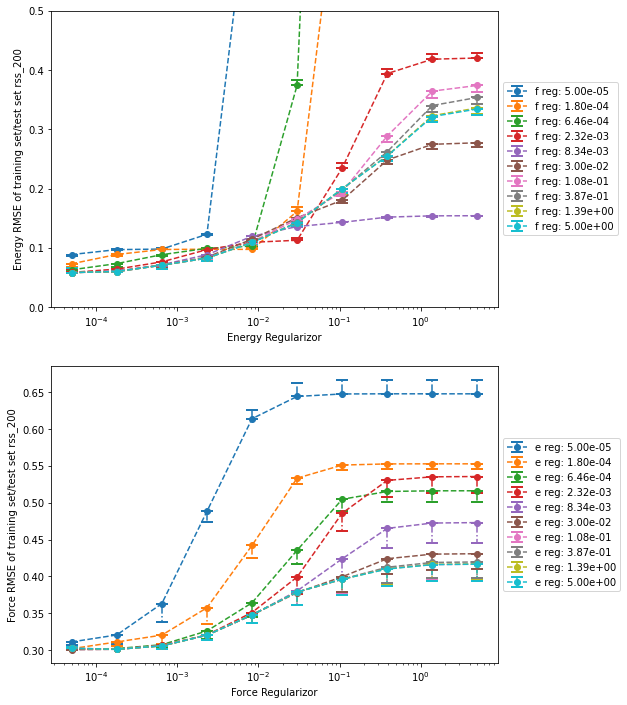

In [25]:
# rss_200

fig, ax = plt.subplots(nrows=2,figsize=(8,12))
key = 'rss_200'
e_reg = np.geomspace(5e-5,5,10)
f_reg = np.geomspace(5e-5,5,10) #4.5e-3

frames_train_temp = [frames_train[i] for i in dataset[key]]
frames_test_temp = [frames_test[i] for i in dataset2[key]]
y_train_temp, f_train_temp, n_train_temp = extract_ref(frames_train_temp,True,True,True)
y_test_temp, f_test_temp, n_test_temp = extract_ref(frames_test_temp,True,True,True)
y_train_temp_atom = y_train_temp/n_train_temp
y_test_temp_atom = y_test_temp/n_test_temp

N_temp = len(dataset[key])
if N_temp > 200:
    n_spa = 200
else:
    n_spa = N_temp

hypers = dict(soap_type="PowerSpectrum",
          interaction_cutoff=5, 
          max_radial=6, 
          max_angular=6, 
          gaussian_sigma_constant=0.4,
          gaussian_sigma_type="Constant",
          cutoff_smooth_width=0.5,
          normalize=False,
          radial_basis="GTO",
          compute_gradients=True,
          expansion_by_species_method='structure wise',
          )

soap = SphericalInvariants(**hypers)
managers_train = soap.transform(frames_train_temp)
managers_test = soap.transform(frames_test_temp)

n_sparse = {15:n_spa}

compressor = FPSFilter(soap, n_sparse, act_on='sample per species')
X_sparse = compressor.select_and_filter(managers_train)

zeta = 1
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

KNM = kernel(managers_train, X_sparse)
KNM_down = kernel(managers_train, X_sparse, grad=(True, False))
KNM = np.vstack([KNM, KNM_down])

rmseFTrain={}
rmseFTest={}
for ee in e_reg:
    rmseFTrain[ee]=[]
    rmseFTest[ee]=[]

for ff in f_reg:
    rmseTrain=[]
    rmseTest=[]

    for ee in e_reg:
        model = train_gap_model(kernel, frames_train_temp, KNM, X_sparse, y_train_temp, self_contributions, 
                                grad_train=-f_train_temp, lambdas=[ee,ff], jitter=1e-13)

        y_pred_train = model.predict(managers_train)
        f_pred_train = model.predict_forces(managers_train)
        y_pred_train_atom = y_pred_train/n_train_temp
        y_pred_test = model.predict(managers_test)
        f_pred_test = model.predict_forces(managers_test)
        y_pred_test_atom = y_pred_test/n_test_temp

        rmse_train = mean_squared_error(y_train_temp_atom, y_pred_train_atom, squared = False)
        rmse_test = mean_squared_error(y_test_temp_atom, y_pred_test_atom, squared = False)
        rmse_ftrain = mean_squared_error(f_train_temp, f_pred_train, squared = False)
        rmse_ftest = mean_squared_error(f_test_temp, f_pred_test, squared = False)
        rmseTest.append(rmse_test)
        rmseTrain.append(rmse_train)
        rmseFTest[ee].append(rmse_ftest)
        rmseFTrain[ee].append(rmse_ftrain)

    errLo = np.zeros((1,len(rmseTest)))
    errUp = (np.array(rmseTest)-np.array(rmseTrain)).reshape(errLo.shape)
    err = np.concatenate((errLo,errUp),axis=0)
    a=ax[0].errorbar(e_reg, rmseTrain,yerr=err,fmt='--o',label='f reg: {:.2e}'.format(ff),capsize=6,capthick=2)
    a[-1][0].set_linestyle('-.')

for ee in rmseFTest.keys():
    errLo_f = np.zeros((1,len(rmseFTest[ee])))
    errUp_f = (np.array(rmseFTest[ee])-np.array(rmseFTrain[ee])).reshape(errLo_f.shape)
    err_f = np.concatenate((errLo_f,errUp_f),axis=0)
    b=ax[1].errorbar(f_reg, rmseFTrain[ee],yerr=err_f,fmt='--o',label='e reg: {:.2e}'.format(ee),capsize=6,capthick=2)
    b[-1][0].set_linestyle('-.')

ax[0].set_xlabel('Energy Regularizor')
ax[0].set_ylabel('Energy RMSE of training set/test set '+str(key))
ax[0].set_xscale('log')
ax[0].set_ylim(bottom=0,top=0.5)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax[1].set_xlabel('Force Regularizor')
ax[1].set_ylabel('Force RMSE of training set/test set '+str(key))
ax[1].set_xscale('log')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

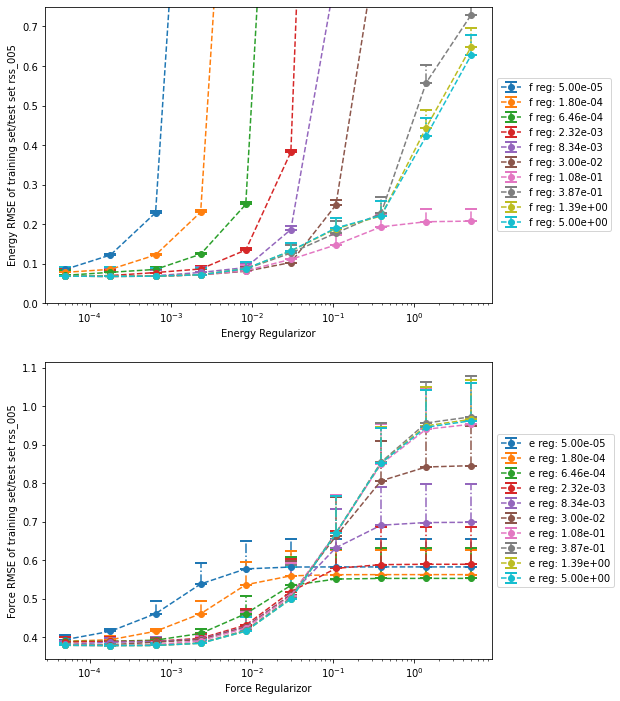

In [7]:
# rss_005

fig, ax = plt.subplots(nrows=2,figsize=(8,12))
key = 'rss_005'
e_reg = np.geomspace(5e-5,5,10)
f_reg = np.geomspace(5e-5,5,10) #1.12e-1

frames_train_temp = [frames_train[i] for i in dataset[key]]
frames_test_temp = [frames_test[i] for i in dataset2[key]]
y_train_temp, f_train_temp, n_train_temp = extract_ref(frames_train_temp,True,True,True)
y_test_temp, f_test_temp, n_test_temp = extract_ref(frames_test_temp,True,True,True)
y_train_temp_atom = y_train_temp/n_train_temp
y_test_temp_atom = y_test_temp/n_test_temp

N_temp = len(dataset[key])
if N_temp > 200:
    n_spa = 200
else:
    n_spa = N_temp

hypers = dict(soap_type="PowerSpectrum",
          interaction_cutoff=5, 
          max_radial=6, 
          max_angular=6, 
          gaussian_sigma_constant=0.4,
          gaussian_sigma_type="Constant",
          cutoff_smooth_width=0.5,
          normalize=False,
          radial_basis="GTO",
          compute_gradients=True,
          expansion_by_species_method='structure wise',
          )

soap = SphericalInvariants(**hypers)
managers_train = soap.transform(frames_train_temp)
managers_test = soap.transform(frames_test_temp)

n_sparse = {15:n_spa}

compressor = FPSFilter(soap, n_sparse, act_on='sample per species')
X_sparse = compressor.select_and_filter(managers_train)

zeta = 1
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

KNM = kernel(managers_train, X_sparse)
KNM_down = kernel(managers_train, X_sparse, grad=(True, False))
KNM = np.vstack([KNM, KNM_down])

rmseFTrain={}
rmseFTest={}
for ee in e_reg:
    rmseFTrain[ee]=[]
    rmseFTest[ee]=[]

for ff in f_reg:
    rmseTrain=[]
    rmseTest=[]

    for ee in e_reg:
        model = train_gap_model(kernel, frames_train_temp, KNM, X_sparse, y_train_temp, self_contributions, 
                                grad_train=-f_train_temp, lambdas=[ee,ff], jitter=1e-13)

        y_pred_train = model.predict(managers_train)
        f_pred_train = model.predict_forces(managers_train)
        y_pred_train_atom = y_pred_train/n_train_temp
        y_pred_test = model.predict(managers_test)
        f_pred_test = model.predict_forces(managers_test)
        y_pred_test_atom = y_pred_test/n_test_temp

        rmse_train = mean_squared_error(y_train_temp_atom, y_pred_train_atom, squared = False)
        rmse_test = mean_squared_error(y_test_temp_atom, y_pred_test_atom, squared = False)
        rmse_ftrain = mean_squared_error(f_train_temp, f_pred_train, squared = False)
        rmse_ftest = mean_squared_error(f_test_temp, f_pred_test, squared = False)
        rmseTest.append(rmse_test)
        rmseTrain.append(rmse_train)
        rmseFTest[ee].append(rmse_ftest)
        rmseFTrain[ee].append(rmse_ftrain)

    errLo = np.zeros((1,len(rmseTest)))
    errUp = (np.array(rmseTest)-np.array(rmseTrain)).reshape(errLo.shape)
    err = np.concatenate((errLo,errUp),axis=0)
    a=ax[0].errorbar(e_reg, rmseTrain,yerr=err,fmt='--o',label='f reg: {:.2e}'.format(ff),capsize=6,capthick=2)
    a[-1][0].set_linestyle('-.')

for ee in rmseFTest.keys():
    errLo_f = np.zeros((1,len(rmseFTest[ee])))
    errUp_f = (np.array(rmseFTest[ee])-np.array(rmseFTrain[ee])).reshape(errLo_f.shape)
    err_f = np.concatenate((errLo_f,errUp_f),axis=0)
    b=ax[1].errorbar(f_reg, rmseFTrain[ee],yerr=err_f,fmt='--o',label='e reg: {:.2e}'.format(ee),capsize=6,capthick=2)
    b[-1][0].set_linestyle('-.')

ax[0].set_xlabel('Energy Regularizor')
ax[0].set_ylabel('Energy RMSE of training set/test set '+str(key))
ax[0].set_xscale('log')
ax[0].set_ylim(0,0.75)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax[1].set_xlabel('Force Regularizor')
ax[1].set_ylabel('Force RMSE of training set/test set '+str(key))
ax[1].set_xscale('log')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

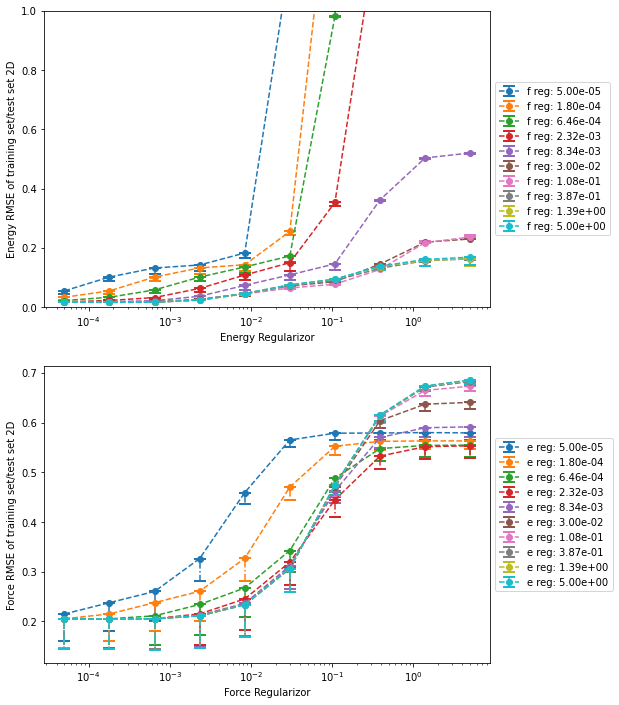

In [8]:
# 2D

fig, ax = plt.subplots(nrows=2,figsize=(8,12))
key = '2D'
e_reg = np.geomspace(5e-5,5,10)
f_reg = np.geomspace(5e-5,5,10)

frames_train_temp = [frames_train[i] for i in dataset[key]]
frames_test_temp = [frames_test[i] for i in dataset2[key]]
y_train_temp, f_train_temp, n_train_temp = extract_ref(frames_train_temp,True,True,True)
y_test_temp, f_test_temp, n_test_temp = extract_ref(frames_test_temp,True,True,True)
y_train_temp_atom = y_train_temp/n_train_temp
y_test_temp_atom = y_test_temp/n_test_temp

N_temp = len(dataset[key])
if N_temp > 200:
    n_spa = 200
else:
    n_spa = N_temp

hypers = dict(soap_type="PowerSpectrum",
          interaction_cutoff=5, 
          max_radial=6, 
          max_angular=6, 
          gaussian_sigma_constant=0.4,
          gaussian_sigma_type="Constant",
          cutoff_smooth_width=0.5,
          normalize=False,
          radial_basis="GTO",
          compute_gradients=True,
          expansion_by_species_method='structure wise',
          )

soap = SphericalInvariants(**hypers)
managers_train = soap.transform(frames_train_temp)
managers_test = soap.transform(frames_test_temp)

n_sparse = {15:n_spa}

compressor = FPSFilter(soap, n_sparse, act_on='sample per species')
X_sparse = compressor.select_and_filter(managers_train)

zeta = 1
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

KNM = kernel(managers_train, X_sparse)
KNM_down = kernel(managers_train, X_sparse, grad=(True, False))
KNM = np.vstack([KNM, KNM_down])

rmseFTrain={}
rmseFTest={}
for ee in e_reg:
    rmseFTrain[ee]=[]
    rmseFTest[ee]=[]

for ff in f_reg:
    rmseTrain=[]
    rmseTest=[]

    for ee in e_reg:
        model = train_gap_model(kernel, frames_train_temp, KNM, X_sparse, y_train_temp, self_contributions, 
                                grad_train=-f_train_temp, lambdas=[ee,ff], jitter=1e-13)

        y_pred_train = model.predict(managers_train)
        f_pred_train = model.predict_forces(managers_train)
        y_pred_train_atom = y_pred_train/n_train_temp
        y_pred_test = model.predict(managers_test)
        f_pred_test = model.predict_forces(managers_test)
        y_pred_test_atom = y_pred_test/n_test_temp

        rmse_train = mean_squared_error(y_train_temp_atom, y_pred_train_atom, squared = False)
        rmse_test = mean_squared_error(y_test_temp_atom, y_pred_test_atom, squared = False)
        rmse_ftrain = mean_squared_error(f_train_temp, f_pred_train, squared = False)
        rmse_ftest = mean_squared_error(f_test_temp, f_pred_test, squared = False)
        rmseTest.append(rmse_test)
        rmseTrain.append(rmse_train)
        rmseFTest[ee].append(rmse_ftest)
        rmseFTrain[ee].append(rmse_ftrain)

    errLo = np.zeros((1,len(rmseTest)))
    errUp = (np.array(rmseTest)-np.array(rmseTrain)).reshape(errLo.shape)
    err = np.concatenate((errLo,errUp),axis=0)
    a=ax[0].errorbar(e_reg, rmseTrain,yerr=err,fmt='--o',label='f reg: {:.2e}'.format(ff),capsize=6,capthick=2)
    a[-1][0].set_linestyle('-.')

for ee in rmseFTest.keys():
    errLo_f = np.zeros((1,len(rmseFTest[ee])))
    errUp_f = (np.array(rmseFTest[ee])-np.array(rmseFTrain[ee])).reshape(errLo_f.shape)
    err_f = np.concatenate((errLo_f,errUp_f),axis=0)
    b=ax[1].errorbar(f_reg, rmseFTrain[ee],yerr=err_f,fmt='--o',label='e reg: {:.2e}'.format(ee),capsize=6,capthick=2)
    b[-1][0].set_linestyle('-.')

ax[0].set_xlabel('Energy Regularizor')
ax[0].set_ylabel('Energy RMSE of training set/test set '+str(key))
ax[0].set_xscale('log')
ax[0].set_ylim(0,1)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax[1].set_xlabel('Force Regularizor')
ax[1].set_ylabel('Force RMSE of training set/test set '+str(key))
ax[1].set_xscale('log')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

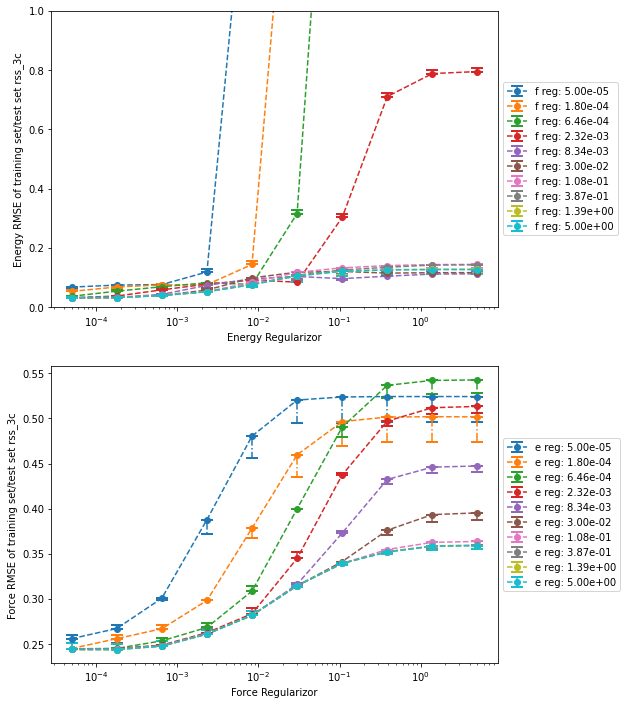

In [9]:
# rss_3c

fig, ax = plt.subplots(nrows=2,figsize=(8,12))
key = 'rss_3c'
e_reg = np.geomspace(5e-5,5,10)
f_reg = np.geomspace(5e-5,5,10)

frames_train_temp = [frames_train[i] for i in dataset[key]]
frames_test_temp = [frames_test[i] for i in dataset2[key]]
y_train_temp, f_train_temp, n_train_temp = extract_ref(frames_train_temp,True,True,True)
y_test_temp, f_test_temp, n_test_temp = extract_ref(frames_test_temp,True,True,True)
y_train_temp_atom = y_train_temp/n_train_temp
y_test_temp_atom = y_test_temp/n_test_temp

N_temp = len(dataset[key])
if N_temp > 200:
    n_spa = 200
else:
    n_spa = N_temp

hypers = dict(soap_type="PowerSpectrum",
          interaction_cutoff=5, 
          max_radial=6, 
          max_angular=6, 
          gaussian_sigma_constant=0.4,
          gaussian_sigma_type="Constant",
          cutoff_smooth_width=0.5,
          normalize=False,
          radial_basis="GTO",
          compute_gradients=True,
          expansion_by_species_method='structure wise',
          )

soap = SphericalInvariants(**hypers)
managers_train = soap.transform(frames_train_temp)
managers_test = soap.transform(frames_test_temp)

n_sparse = {15:n_spa}

compressor = FPSFilter(soap, n_sparse, act_on='sample per species')
X_sparse = compressor.select_and_filter(managers_train)

zeta = 1
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

KNM = kernel(managers_train, X_sparse)
KNM_down = kernel(managers_train, X_sparse, grad=(True, False))
KNM = np.vstack([KNM, KNM_down])

rmseFTrain={}
rmseFTest={}
for ee in e_reg:
    rmseFTrain[ee]=[]
    rmseFTest[ee]=[]

for ff in f_reg:
    rmseTrain=[]
    rmseTest=[]

    for ee in e_reg:
        model = train_gap_model(kernel, frames_train_temp, KNM, X_sparse, y_train_temp, self_contributions, 
                                grad_train=-f_train_temp, lambdas=[ee,ff], jitter=1e-13)

        y_pred_train = model.predict(managers_train)
        f_pred_train = model.predict_forces(managers_train)
        y_pred_train_atom = y_pred_train/n_train_temp
        y_pred_test = model.predict(managers_test)
        f_pred_test = model.predict_forces(managers_test)
        y_pred_test_atom = y_pred_test/n_test_temp

        rmse_train = mean_squared_error(y_train_temp_atom, y_pred_train_atom, squared = False)
        rmse_test = mean_squared_error(y_test_temp_atom, y_pred_test_atom, squared = False)
        rmse_ftrain = mean_squared_error(f_train_temp, f_pred_train, squared = False)
        rmse_ftest = mean_squared_error(f_test_temp, f_pred_test, squared = False)
        rmseTest.append(rmse_test)
        rmseTrain.append(rmse_train)
        rmseFTest[ee].append(rmse_ftest)
        rmseFTrain[ee].append(rmse_ftrain)

    errLo = np.zeros((1,len(rmseTest)))
    errUp = (np.array(rmseTest)-np.array(rmseTrain)).reshape(errLo.shape)
    err = np.concatenate((errLo,errUp),axis=0)
    a=ax[0].errorbar(e_reg, rmseTrain,yerr=err,fmt='--o',label='f reg: {:.2e}'.format(ff),capsize=6,capthick=2)
    a[-1][0].set_linestyle('-.')

for ee in rmseFTest.keys():
    errLo_f = np.zeros((1,len(rmseFTest[ee])))
    errUp_f = (np.array(rmseFTest[ee])-np.array(rmseFTrain[ee])).reshape(errLo_f.shape)
    err_f = np.concatenate((errLo_f,errUp_f),axis=0)
    b=ax[1].errorbar(f_reg, rmseFTrain[ee],yerr=err_f,fmt='--o',label='e reg: {:.2e}'.format(ee),capsize=6,capthick=2)
    b[-1][0].set_linestyle('-.')

ax[0].set_xlabel('Energy Regularizor')
ax[0].set_ylabel('Energy RMSE of training set/test set '+str(key))
ax[0].set_xscale('log')
ax[0].set_ylim(0,1)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax[1].set_xlabel('Force Regularizor')
ax[1].set_ylabel('Force RMSE of training set/test set '+str(key))
ax[1].set_xscale('log')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

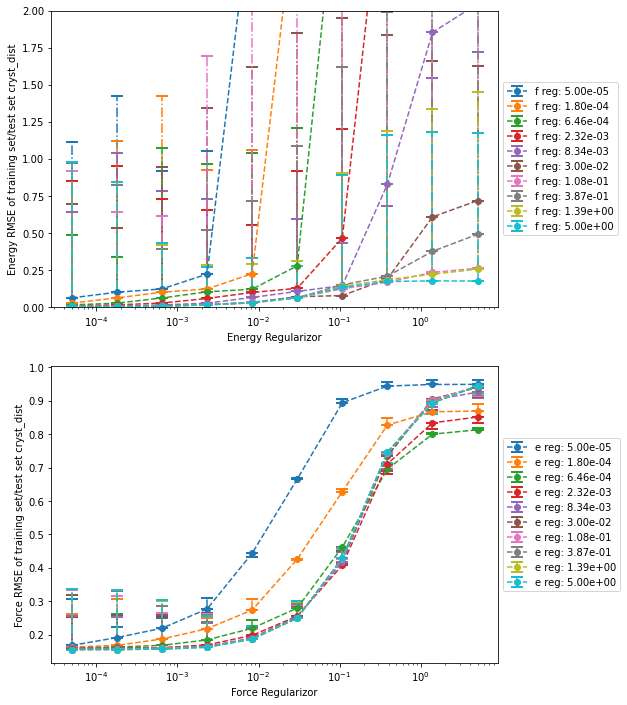

In [11]:
# cryst_dist

fig, ax = plt.subplots(nrows=2,figsize=(8,12))
key = 'cryst_dist'
e_reg = np.geomspace(5e-5,5,10)
f_reg = np.geomspace(5e-5,5,10)

frames_train_temp = [frames_train[i] for i in dataset[key]]
frames_test_temp = [frames_test[i] for i in dataset2[key]]
y_train_temp, f_train_temp, n_train_temp = extract_ref(frames_train_temp,True,True,True)
y_test_temp, f_test_temp, n_test_temp = extract_ref(frames_test_temp,True,True,True)
y_train_temp_atom = y_train_temp/n_train_temp
y_test_temp_atom = y_test_temp/n_test_temp

N_temp = len(dataset[key])
if N_temp > 200:
    n_spa = 200
else:
    n_spa = N_temp

hypers = dict(soap_type="PowerSpectrum",
          interaction_cutoff=5, 
          max_radial=6, 
          max_angular=6, 
          gaussian_sigma_constant=0.4,
          gaussian_sigma_type="Constant",
          cutoff_smooth_width=0.5,
          normalize=False,
          radial_basis="GTO",
          compute_gradients=True,
          expansion_by_species_method='structure wise',
          )

soap = SphericalInvariants(**hypers)
managers_train = soap.transform(frames_train_temp)
managers_test = soap.transform(frames_test_temp)

n_sparse = {15:n_spa}

compressor = FPSFilter(soap, n_sparse, act_on='sample per species')
X_sparse = compressor.select_and_filter(managers_train)

zeta = 1
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

KNM = kernel(managers_train, X_sparse)
KNM_down = kernel(managers_train, X_sparse, grad=(True, False))
KNM = np.vstack([KNM, KNM_down])

rmseFTrain={}
rmseFTest={}
for ee in e_reg:
    rmseFTrain[ee]=[]
    rmseFTest[ee]=[]

for ff in f_reg:
    rmseTrain=[]
    rmseTest=[]

    for ee in e_reg:
        model = train_gap_model(kernel, frames_train_temp, KNM, X_sparse, y_train_temp, self_contributions, 
                                grad_train=-f_train_temp, lambdas=[ee,ff], jitter=1e-13)

        y_pred_train = model.predict(managers_train)
        f_pred_train = model.predict_forces(managers_train)
        y_pred_train_atom = y_pred_train/n_train_temp
        y_pred_test = model.predict(managers_test)
        f_pred_test = model.predict_forces(managers_test)
        y_pred_test_atom = y_pred_test/n_test_temp

        rmse_train = mean_squared_error(y_train_temp_atom, y_pred_train_atom, squared = False)
        rmse_test = mean_squared_error(y_test_temp_atom, y_pred_test_atom, squared = False)
        rmse_ftrain = mean_squared_error(f_train_temp, f_pred_train, squared = False)
        rmse_ftest = mean_squared_error(f_test_temp, f_pred_test, squared = False)
        rmseTest.append(rmse_test)
        rmseTrain.append(rmse_train)
        rmseFTest[ee].append(rmse_ftest)
        rmseFTrain[ee].append(rmse_ftrain)

    errLo = np.zeros((1,len(rmseTest)))
    errUp = (np.array(rmseTest)-np.array(rmseTrain)).reshape(errLo.shape)
    err = np.concatenate((errLo,errUp),axis=0)
    a=ax[0].errorbar(e_reg, rmseTrain,yerr=err,fmt='--o',label='f reg: {:.2e}'.format(ff),capsize=6,capthick=2)
    a[-1][0].set_linestyle('-.')

for ee in rmseFTest.keys():
    errLo_f = np.zeros((1,len(rmseFTest[ee])))
    errUp_f = (np.array(rmseFTest[ee])-np.array(rmseFTrain[ee])).reshape(errLo_f.shape)
    err_f = np.concatenate((errLo_f,errUp_f),axis=0)
    b=ax[1].errorbar(f_reg, rmseFTrain[ee],yerr=err_f,fmt='--o',label='e reg: {:.2e}'.format(ee),capsize=6,capthick=2)
    b[-1][0].set_linestyle('-.')

ax[0].set_xlabel('Energy Regularizor')
ax[0].set_ylabel('Energy RMSE of training set/test set '+str(key))
ax[0].set_xscale('log')
ax[0].set_ylim(0,2)
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax[1].set_xlabel('Force Regularizor')
ax[1].set_ylabel('Force RMSE of training set/test set '+str(key))
ax[1].set_xscale('log')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

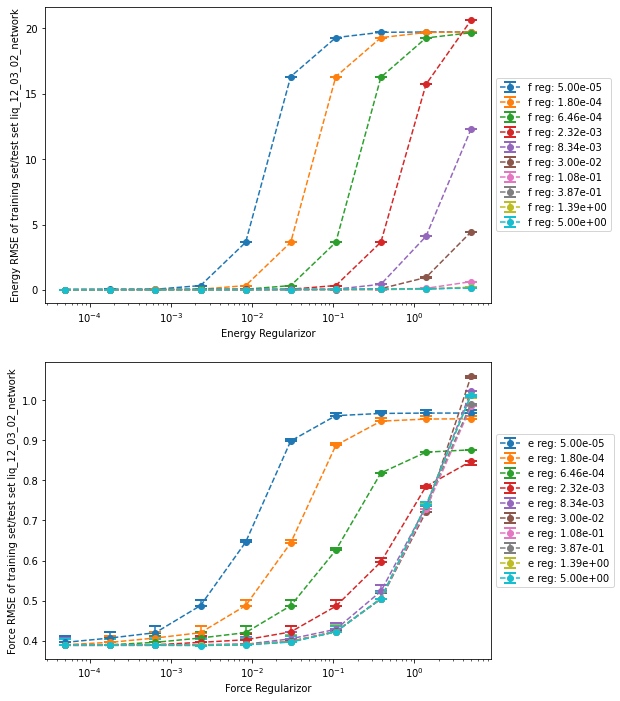

In [14]:
# liq_12_03_02_network

fig, ax = plt.subplots(nrows=2,figsize=(8,12))
key = 'liq_12_03_02_network'
e_reg = np.geomspace(5e-5,5,10)
f_reg = np.geomspace(5e-5,5,10)

frames_train_temp = [frames_train[i] for i in dataset[key]]
frames_test_temp = [frames_test[i] for i in dataset2[key]]
y_train_temp, f_train_temp, n_train_temp = extract_ref(frames_train_temp,True,True,True)
y_test_temp, f_test_temp, n_test_temp = extract_ref(frames_test_temp,True,True,True)
y_train_temp_atom = y_train_temp/n_train_temp
y_test_temp_atom = y_test_temp/n_test_temp

N_temp = len(dataset[key])
if N_temp > 200:
    n_spa = 200
else:
    n_spa = N_temp

hypers = dict(soap_type="PowerSpectrum",
          interaction_cutoff=5, 
          max_radial=6, 
          max_angular=6, 
          gaussian_sigma_constant=0.4,
          gaussian_sigma_type="Constant",
          cutoff_smooth_width=0.5,
          normalize=False,
          radial_basis="GTO",
          compute_gradients=True,
          expansion_by_species_method='structure wise',
          )

soap = SphericalInvariants(**hypers)
managers_train = soap.transform(frames_train_temp)
managers_test = soap.transform(frames_test_temp)

n_sparse = {15:n_spa}

compressor = FPSFilter(soap, n_sparse, act_on='sample per species')
X_sparse = compressor.select_and_filter(managers_train)

zeta = 1
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

KNM = kernel(managers_train, X_sparse)
KNM_down = kernel(managers_train, X_sparse, grad=(True, False))
KNM = np.vstack([KNM, KNM_down])

rmseFTrain={}
rmseFTest={}
for ee in e_reg:
    rmseFTrain[ee]=[]
    rmseFTest[ee]=[]

for ff in f_reg:
    rmseTrain=[]
    rmseTest=[]

    for ee in e_reg:
        model = train_gap_model(kernel, frames_train_temp, KNM, X_sparse, y_train_temp, self_contributions, 
                                grad_train=-f_train_temp, lambdas=[ee,ff], jitter=1e-13)

        y_pred_train = model.predict(managers_train)
        f_pred_train = model.predict_forces(managers_train)
        y_pred_train_atom = y_pred_train/n_train_temp
        y_pred_test = model.predict(managers_test)
        f_pred_test = model.predict_forces(managers_test)
        y_pred_test_atom = y_pred_test/n_test_temp

        rmse_train = mean_squared_error(y_train_temp_atom, y_pred_train_atom, squared = False)
        rmse_test = mean_squared_error(y_test_temp_atom, y_pred_test_atom, squared = False)
        rmse_ftrain = mean_squared_error(f_train_temp, f_pred_train, squared = False)
        rmse_ftest = mean_squared_error(f_test_temp, f_pred_test, squared = False)
        rmseTest.append(rmse_test)
        rmseTrain.append(rmse_train)
        rmseFTest[ee].append(rmse_ftest)
        rmseFTrain[ee].append(rmse_ftrain)

    errLo = np.zeros((1,len(rmseTest)))
    errUp = (np.array(rmseTest)-np.array(rmseTrain)).reshape(errLo.shape)
    err = np.concatenate((errLo,errUp),axis=0)
    a=ax[0].errorbar(e_reg, rmseTrain,yerr=err,fmt='--o',label='f reg: {:.2e}'.format(ff),capsize=6,capthick=2)
    a[-1][0].set_linestyle('-.')

for ee in rmseFTest.keys():
    errLo_f = np.zeros((1,len(rmseFTest[ee])))
    errUp_f = (np.array(rmseFTest[ee])-np.array(rmseFTrain[ee])).reshape(errLo_f.shape)
    err_f = np.concatenate((errLo_f,errUp_f),axis=0)
    b=ax[1].errorbar(f_reg, rmseFTrain[ee],yerr=err_f,fmt='--o',label='e reg: {:.2e}'.format(ee),capsize=6,capthick=2)
    b[-1][0].set_linestyle('-.')

ax[0].set_xlabel('Energy Regularizor')
ax[0].set_ylabel('Energy RMSE of training set/test set '+str(key))
ax[0].set_xscale('log')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax[1].set_xlabel('Force Regularizor')
ax[1].set_ylabel('Force RMSE of training set/test set '+str(key))
ax[1].set_xscale('log')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

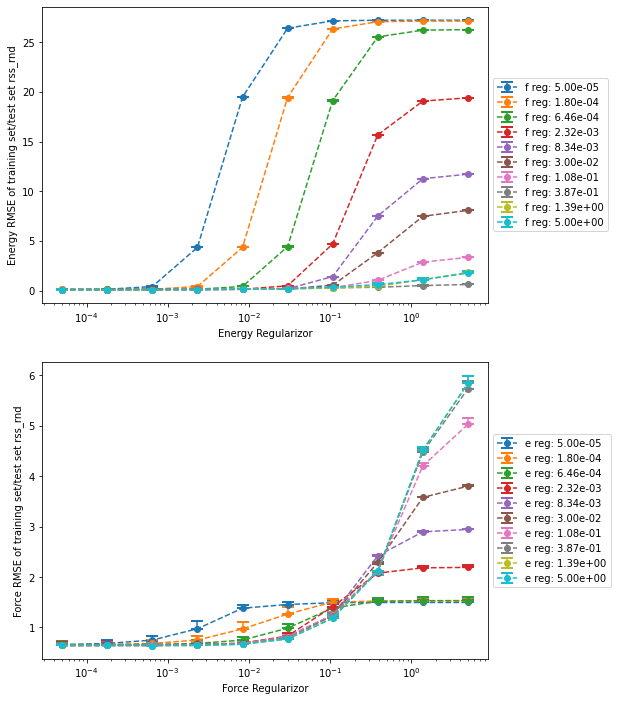

In [15]:
# rss_rnd

fig, ax = plt.subplots(nrows=2,figsize=(8,12))
key = 'rss_rnd'
e_reg = np.geomspace(5e-5,5,10)
f_reg = np.geomspace(5e-5,5,10)

frames_train_temp = [frames_train[i] for i in dataset[key]]
frames_test_temp = [frames_test[i] for i in dataset2[key]]
y_train_temp, f_train_temp, n_train_temp = extract_ref(frames_train_temp,True,True,True)
y_test_temp, f_test_temp, n_test_temp = extract_ref(frames_test_temp,True,True,True)
y_train_temp_atom = y_train_temp/n_train_temp
y_test_temp_atom = y_test_temp/n_test_temp

N_temp = len(dataset[key])
if N_temp > 200:
    n_spa = 200
else:
    n_spa = N_temp

hypers = dict(soap_type="PowerSpectrum",
          interaction_cutoff=5, 
          max_radial=6, 
          max_angular=6, 
          gaussian_sigma_constant=0.4,
          gaussian_sigma_type="Constant",
          cutoff_smooth_width=0.5,
          normalize=False,
          radial_basis="GTO",
          compute_gradients=True,
          expansion_by_species_method='structure wise',
          )

soap = SphericalInvariants(**hypers)
managers_train = soap.transform(frames_train_temp)
managers_test = soap.transform(frames_test_temp)

n_sparse = {15:n_spa}

compressor = FPSFilter(soap, n_sparse, act_on='sample per species')
X_sparse = compressor.select_and_filter(managers_train)

zeta = 1
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

KNM = kernel(managers_train, X_sparse)
KNM_down = kernel(managers_train, X_sparse, grad=(True, False))
KNM = np.vstack([KNM, KNM_down])

rmseFTrain={}
rmseFTest={}
for ee in e_reg:
    rmseFTrain[ee]=[]
    rmseFTest[ee]=[]

for ff in f_reg:
    rmseTrain=[]
    rmseTest=[]

    for ee in e_reg:
        model = train_gap_model(kernel, frames_train_temp, KNM, X_sparse, y_train_temp, self_contributions, 
                                grad_train=-f_train_temp, lambdas=[ee,ff], jitter=1e-13)

        y_pred_train = model.predict(managers_train)
        f_pred_train = model.predict_forces(managers_train)
        y_pred_train_atom = y_pred_train/n_train_temp
        y_pred_test = model.predict(managers_test)
        f_pred_test = model.predict_forces(managers_test)
        y_pred_test_atom = y_pred_test/n_test_temp

        rmse_train = mean_squared_error(y_train_temp_atom, y_pred_train_atom, squared = False)
        rmse_test = mean_squared_error(y_test_temp_atom, y_pred_test_atom, squared = False)
        rmse_ftrain = mean_squared_error(f_train_temp, f_pred_train, squared = False)
        rmse_ftest = mean_squared_error(f_test_temp, f_pred_test, squared = False)
        rmseTest.append(rmse_test)
        rmseTrain.append(rmse_train)
        rmseFTest[ee].append(rmse_ftest)
        rmseFTrain[ee].append(rmse_ftrain)

    errLo = np.zeros((1,len(rmseTest)))
    errUp = (np.array(rmseTest)-np.array(rmseTrain)).reshape(errLo.shape)
    err = np.concatenate((errLo,errUp),axis=0)
    a=ax[0].errorbar(e_reg, rmseTrain,yerr=err,fmt='--o',label='f reg: {:.2e}'.format(ff),capsize=6,capthick=2)
    a[-1][0].set_linestyle('-.')

for ee in rmseFTest.keys():
    errLo_f = np.zeros((1,len(rmseFTest[ee])))
    errUp_f = (np.array(rmseFTest[ee])-np.array(rmseFTrain[ee])).reshape(errLo_f.shape)
    err_f = np.concatenate((errLo_f,errUp_f),axis=0)
    b=ax[1].errorbar(f_reg, rmseFTrain[ee],yerr=err_f,fmt='--o',label='e reg: {:.2e}'.format(ee),capsize=6,capthick=2)
    b[-1][0].set_linestyle('-.')

ax[0].set_xlabel('Energy Regularizor')
ax[0].set_ylabel('Energy RMSE of training set/test set '+str(key))
ax[0].set_xscale('log')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax[1].set_xlabel('Force Regularizor')
ax[1].set_ylabel('Force RMSE of training set/test set '+str(key))
ax[1].set_xscale('log')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

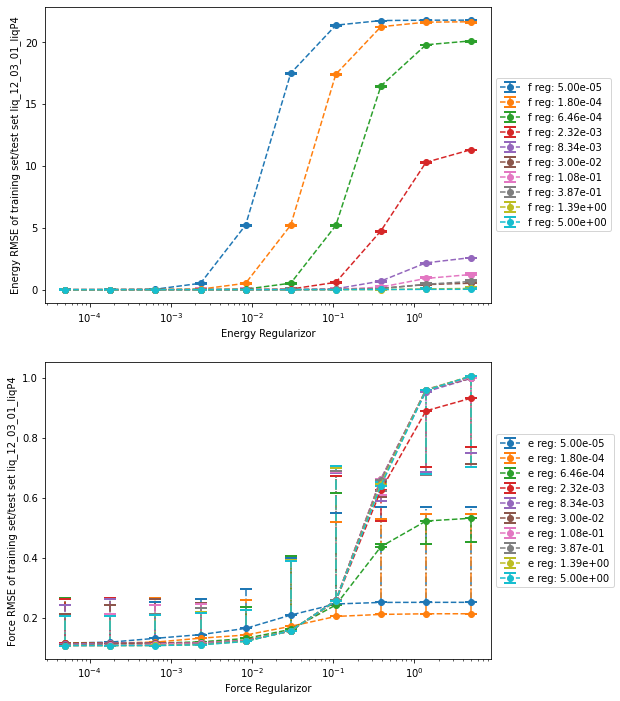

In [16]:
# liq_12_03_01_liqP4

fig, ax = plt.subplots(nrows=2,figsize=(8,12))
key = 'liq_12_03_01_liqP4'
e_reg = np.geomspace(5e-5,5,10)
f_reg = np.geomspace(5e-5,5,10)

frames_train_temp = [frames_train[i] for i in dataset[key]]
frames_test_temp = [frames_test[i] for i in dataset2[key]]
y_train_temp, f_train_temp, n_train_temp = extract_ref(frames_train_temp,True,True,True)
y_test_temp, f_test_temp, n_test_temp = extract_ref(frames_test_temp,True,True,True)
y_train_temp_atom = y_train_temp/n_train_temp
y_test_temp_atom = y_test_temp/n_test_temp

N_temp = len(dataset[key])
if N_temp > 200:
    n_spa = 200
else:
    n_spa = N_temp

hypers = dict(soap_type="PowerSpectrum",
          interaction_cutoff=5, 
          max_radial=6, 
          max_angular=6, 
          gaussian_sigma_constant=0.4,
          gaussian_sigma_type="Constant",
          cutoff_smooth_width=0.5,
          normalize=False,
          radial_basis="GTO",
          compute_gradients=True,
          expansion_by_species_method='structure wise',
          )

soap = SphericalInvariants(**hypers)
managers_train = soap.transform(frames_train_temp)
managers_test = soap.transform(frames_test_temp)

n_sparse = {15:n_spa}

compressor = FPSFilter(soap, n_sparse, act_on='sample per species')
X_sparse = compressor.select_and_filter(managers_train)

zeta = 1
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

KNM = kernel(managers_train, X_sparse)
KNM_down = kernel(managers_train, X_sparse, grad=(True, False))
KNM = np.vstack([KNM, KNM_down])

rmseFTrain={}
rmseFTest={}
for ee in e_reg:
    rmseFTrain[ee]=[]
    rmseFTest[ee]=[]

for ff in f_reg:
    rmseTrain=[]
    rmseTest=[]

    for ee in e_reg:
        model = train_gap_model(kernel, frames_train_temp, KNM, X_sparse, y_train_temp, self_contributions, 
                                grad_train=-f_train_temp, lambdas=[ee,ff], jitter=1e-13)

        y_pred_train = model.predict(managers_train)
        f_pred_train = model.predict_forces(managers_train)
        y_pred_train_atom = y_pred_train/n_train_temp
        y_pred_test = model.predict(managers_test)
        f_pred_test = model.predict_forces(managers_test)
        y_pred_test_atom = y_pred_test/n_test_temp

        rmse_train = mean_squared_error(y_train_temp_atom, y_pred_train_atom, squared = False)
        rmse_test = mean_squared_error(y_test_temp_atom, y_pred_test_atom, squared = False)
        rmse_ftrain = mean_squared_error(f_train_temp, f_pred_train, squared = False)
        rmse_ftest = mean_squared_error(f_test_temp, f_pred_test, squared = False)
        rmseTest.append(rmse_test)
        rmseTrain.append(rmse_train)
        rmseFTest[ee].append(rmse_ftest)
        rmseFTrain[ee].append(rmse_ftrain)

    errLo = np.zeros((1,len(rmseTest)))
    errUp = (np.array(rmseTest)-np.array(rmseTrain)).reshape(errLo.shape)
    err = np.concatenate((errLo,errUp),axis=0)
    a=ax[0].errorbar(e_reg, rmseTrain,yerr=err,fmt='--o',label='f reg: {:.2e}'.format(ff),capsize=6,capthick=2)
    a[-1][0].set_linestyle('-.')

for ee in rmseFTest.keys():
    errLo_f = np.zeros((1,len(rmseFTest[ee])))
    errUp_f = (np.array(rmseFTest[ee])-np.array(rmseFTrain[ee])).reshape(errLo_f.shape)
    err_f = np.concatenate((errLo_f,errUp_f),axis=0)
    b=ax[1].errorbar(f_reg, rmseFTrain[ee],yerr=err_f,fmt='--o',label='e reg: {:.2e}'.format(ee),capsize=6,capthick=2)
    b[-1][0].set_linestyle('-.')

ax[0].set_xlabel('Energy Regularizor')
ax[0].set_ylabel('Energy RMSE of training set/test set '+str(key))
ax[0].set_xscale('log')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax[1].set_xlabel('Force Regularizor')
ax[1].set_ylabel('Force RMSE of training set/test set '+str(key))
ax[1].set_xscale('log')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

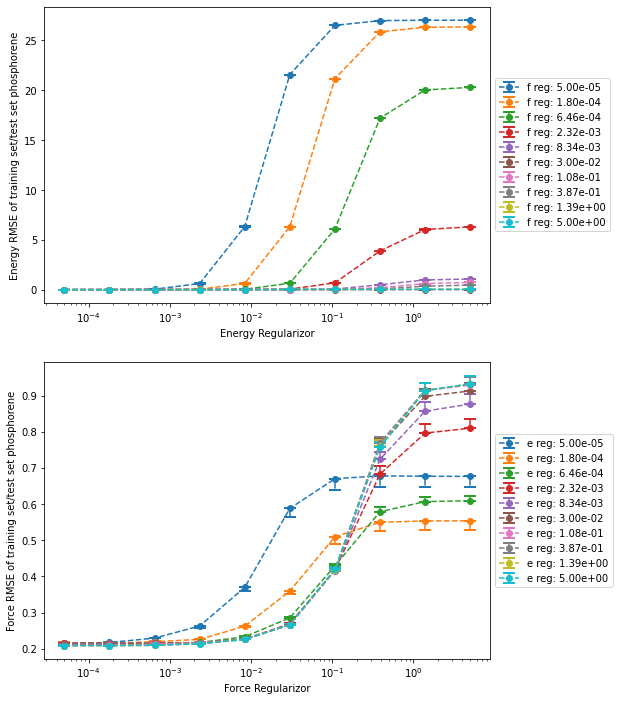

In [17]:
# phosphorene
fig, ax = plt.subplots(nrows=2,figsize=(8,12))
key = 'phosphorene'
e_reg = np.geomspace(5e-5,5,10)
f_reg = np.geomspace(5e-5,5,10)

frames_train_raw = [frames_train[i] for i in dataset[key]]

N = len(dataset[key])
f=int(0.8*N)

ids = list(range(N))
np.random.seed(10)
np.random.shuffle(ids)

frames_train_temp = [frames_train_raw[ii] for ii in ids[:f]]
frames_test_temp = [frames_train_raw[ii] for ii in ids[f:]]
y_train_temp, f_train_temp, n_train_temp = extract_ref(frames_train_temp,True,True,True)
y_test_temp, f_test_temp, n_test_temp = extract_ref(frames_test_temp,True,True,True)
y_train_temp_atom = y_train_temp/n_train_temp
y_test_temp_atom = y_test_temp/n_test_temp

N_temp = len(dataset[key])
if N_temp > 200:
    n_spa = 200
else:
    n_spa = N_temp

hypers = dict(soap_type="PowerSpectrum",
          interaction_cutoff=5, 
          max_radial=6, 
          max_angular=6, 
          gaussian_sigma_constant=0.4,
          gaussian_sigma_type="Constant",
          cutoff_smooth_width=0.5,
          normalize=False,
          radial_basis="GTO",
          compute_gradients=True,
          expansion_by_species_method='structure wise',
          )

soap = SphericalInvariants(**hypers)
managers_train = soap.transform(frames_train_temp)
managers_test = soap.transform(frames_test_temp)

n_sparse = {15:n_spa}

compressor = FPSFilter(soap, n_sparse, act_on='sample per species')
X_sparse = compressor.select_and_filter(managers_train)

zeta = 1
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

KNM = kernel(managers_train, X_sparse)
KNM_down = kernel(managers_train, X_sparse, grad=(True, False))
KNM = np.vstack([KNM, KNM_down])

rmseFTrain={}
rmseFTest={}
for ee in e_reg:
    rmseFTrain[ee]=[]
    rmseFTest[ee]=[]

for ff in f_reg:
    rmseTrain=[]
    rmseTest=[]

    for ee in e_reg:
        model = train_gap_model(kernel, frames_train_temp, KNM, X_sparse, y_train_temp, self_contributions, 
                                grad_train=-f_train_temp, lambdas=[ee,ff], jitter=1e-13)

        y_pred_train = model.predict(managers_train)
        f_pred_train = model.predict_forces(managers_train)
        y_pred_train_atom = y_pred_train/n_train_temp
        y_pred_test = model.predict(managers_test)
        f_pred_test = model.predict_forces(managers_test)
        y_pred_test_atom = y_pred_test/n_test_temp

        rmse_train = mean_squared_error(y_train_temp_atom, y_pred_train_atom, squared = False)
        rmse_test = mean_squared_error(y_test_temp_atom, y_pred_test_atom, squared = False)
        rmse_ftrain = mean_squared_error(f_train_temp, f_pred_train, squared = False)
        rmse_ftest = mean_squared_error(f_test_temp, f_pred_test, squared = False)
        rmseTest.append(rmse_test)
        rmseTrain.append(rmse_train)
        rmseFTest[ee].append(rmse_ftest)
        rmseFTrain[ee].append(rmse_ftrain)

    errLo = np.zeros((1,len(rmseTest)))
    errUp = (np.array(rmseTest)-np.array(rmseTrain)).reshape(errLo.shape)
    err = np.concatenate((errLo,errUp),axis=0)
    a=ax[0].errorbar(e_reg, rmseTrain,yerr=err,fmt='--o',label='f reg: {:.2e}'.format(ff),capsize=6,capthick=2)
    a[-1][0].set_linestyle('-.')

for ee in rmseFTest.keys():
    errLo_f = np.zeros((1,len(rmseFTest[ee])))
    errUp_f = (np.array(rmseFTest[ee])-np.array(rmseFTrain[ee])).reshape(errLo_f.shape)
    err_f = np.concatenate((errLo_f,errUp_f),axis=0)
    b=ax[1].errorbar(f_reg, rmseFTrain[ee],yerr=err_f,fmt='--o',label='e reg: {:.2e}'.format(ee),capsize=6,capthick=2)
    b[-1][0].set_linestyle('-.')

ax[0].set_xlabel('Energy Regularizor')
ax[0].set_ylabel('Energy RMSE of training set/test set '+str(key))
ax[0].set_xscale('log')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax[1].set_xlabel('Force Regularizor')
ax[1].set_ylabel('Force RMSE of training set/test set '+str(key))
ax[1].set_xscale('log')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

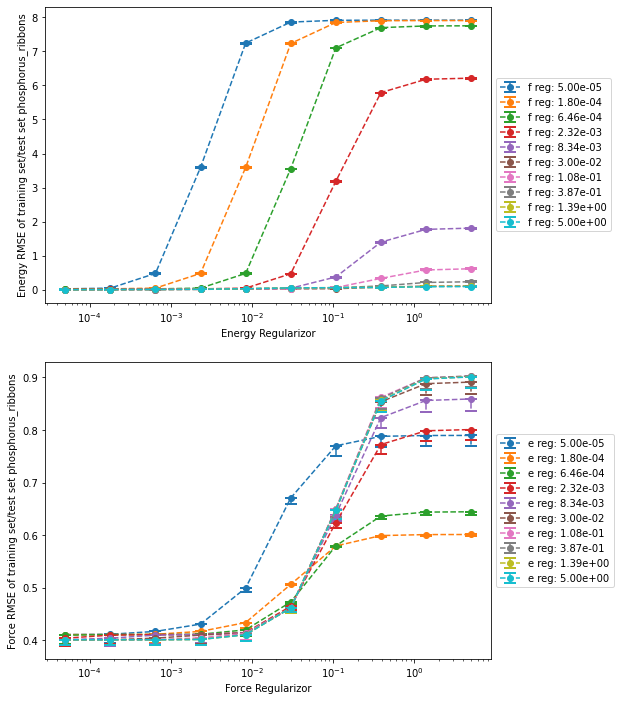

In [18]:
# phosphorus_ribbons
key = 'phosphorus_ribbons'
fig, ax = plt.subplots(nrows=2,figsize=(8,12))
e_reg = np.geomspace(5e-5,5,10)
f_reg = np.geomspace(5e-5,5,10)

frames_train_raw = [frames_train[i] for i in dataset[key]]

N = len(dataset[key])
f=int(0.8*N)

ids = list(range(N))
np.random.seed(10)
np.random.shuffle(ids)

frames_train_temp = [frames_train_raw[ii] for ii in ids[:f]]
frames_test_temp = [frames_train_raw[ii] for ii in ids[f:]]
y_train_temp, f_train_temp, n_train_temp = extract_ref(frames_train_temp,True,True,True)
y_test_temp, f_test_temp, n_test_temp = extract_ref(frames_test_temp,True,True,True)
y_train_temp_atom = y_train_temp/n_train_temp
y_test_temp_atom = y_test_temp/n_test_temp

N_temp = len(dataset[key])
if N_temp > 200:
    n_spa = 200
else:
    n_spa = N_temp

hypers = dict(soap_type="PowerSpectrum",
          interaction_cutoff=5, 
          max_radial=6, 
          max_angular=6, 
          gaussian_sigma_constant=0.4,
          gaussian_sigma_type="Constant",
          cutoff_smooth_width=0.5,
          normalize=False,
          radial_basis="GTO",
          compute_gradients=True,
          expansion_by_species_method='structure wise',
          )

soap = SphericalInvariants(**hypers)
managers_train = soap.transform(frames_train_temp)
managers_test = soap.transform(frames_test_temp)

n_sparse = {15:n_spa}

compressor = FPSFilter(soap, n_sparse, act_on='sample per species')
X_sparse = compressor.select_and_filter(managers_train)

zeta = 1
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

KNM = kernel(managers_train, X_sparse)
KNM_down = kernel(managers_train, X_sparse, grad=(True, False))
KNM = np.vstack([KNM, KNM_down])

rmseFTrain={}
rmseFTest={}
for ee in e_reg:
    rmseFTrain[ee]=[]
    rmseFTest[ee]=[]

for ff in f_reg:
    rmseTrain=[]
    rmseTest=[]

    for ee in e_reg:
        model = train_gap_model(kernel, frames_train_temp, KNM, X_sparse, y_train_temp, self_contributions, 
                                grad_train=-f_train_temp, lambdas=[ee,ff], jitter=1e-13)

        y_pred_train = model.predict(managers_train)
        f_pred_train = model.predict_forces(managers_train)
        y_pred_train_atom = y_pred_train/n_train_temp
        y_pred_test = model.predict(managers_test)
        f_pred_test = model.predict_forces(managers_test)
        y_pred_test_atom = y_pred_test/n_test_temp

        rmse_train = mean_squared_error(y_train_temp_atom, y_pred_train_atom, squared = False)
        rmse_test = mean_squared_error(y_test_temp_atom, y_pred_test_atom, squared = False)
        rmse_ftrain = mean_squared_error(f_train_temp, f_pred_train, squared = False)
        rmse_ftest = mean_squared_error(f_test_temp, f_pred_test, squared = False)
        rmseTest.append(rmse_test)
        rmseTrain.append(rmse_train)
        rmseFTest[ee].append(rmse_ftest)
        rmseFTrain[ee].append(rmse_ftrain)

    errLo = np.zeros((1,len(rmseTest)))
    errUp = (np.array(rmseTest)-np.array(rmseTrain)).reshape(errLo.shape)
    err = np.concatenate((errLo,errUp),axis=0)
    a=ax[0].errorbar(e_reg, rmseTrain,yerr=err,fmt='--o',label='f reg: {:.2e}'.format(ff),capsize=6,capthick=2)
    a[-1][0].set_linestyle('-.')

for ee in rmseFTest.keys():
    errLo_f = np.zeros((1,len(rmseFTest[ee])))
    errUp_f = (np.array(rmseFTest[ee])-np.array(rmseFTrain[ee])).reshape(errLo_f.shape)
    err_f = np.concatenate((errLo_f,errUp_f),axis=0)
    b=ax[1].errorbar(f_reg, rmseFTrain[ee],yerr=err_f,fmt='--o',label='e reg: {:.2e}'.format(ee),capsize=6,capthick=2)
    b[-1][0].set_linestyle('-.')

ax[0].set_xlabel('Energy Regularizor')
ax[0].set_ylabel('Energy RMSE of training set/test set '+str(key))
ax[0].set_xscale('log')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax[1].set_xlabel('Force Regularizor')
ax[1].set_ylabel('Force RMSE of training set/test set '+str(key))
ax[1].set_xscale('log')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))